In [1]:
#Imports
import pandas as pd
import os
import tensorflow as tf
from tslearn.clustering import TimeSeriesKMeans
from keras import backend as K
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.metrics import dtw

In [2]:
#Get data 

cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
df = pd.read_csv(cwd+'/data/3final_data/Final_Energy_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Filter for the first 30 'load' and 'pv' columns using list comprehension
columns_to_keep = [
    col for col in df.columns 
    if (col.startswith('load_') or col.startswith('pv_')) and int(col.split('_')[1]) <= 30
]
filtered_df = df[columns_to_keep]

# Calculate prosumption for each user
prosumption_df = pd.DataFrame(index=df.index)
for i in range(1, 31):  # Assuming 30 users
    load_col = f'load_{i}'
    pv_col = f'pv_{i}'
    if load_col in filtered_df.columns and pv_col in filtered_df.columns:
        prosumption_df[f'prosumption_{i}'] = filtered_df[pv_col] - filtered_df[load_col]

#Only keep month 3,7,11 of the data to limit computational time
prosumption_df = prosumption_df[prosumption_df.index.month.isin([3, 7, 11])]
prosumption_df = prosumption_df[prosumption_df.index.day.isin([1,2,3,4,5,6,7,8,9,10])]

prosumption_df.head(1)

,prosumption_1,prosumption_2,prosumption_3,prosumption_4,prosumption_5,prosumption_6,prosumption_7,prosumption_8,prosumption_9,prosumption_10,...,prosumption_21,prosumption_22,prosumption_23,prosumption_24,prosumption_25,prosumption_26,prosumption_27,prosumption_28,prosumption_29,prosumption_30
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-01 00:30:00,-1.553,-0.085,-2.698,-0.075,-1.917,-0.044,-1.831,-0.124,-0.033,-0.031,...,-0.896,-0.072,-0.111,-0.146,-0.1,-0.375,-0.265,-0.1,-0.103,-2.461


In [3]:
#Prepare data

time_series = prosumption_df.T.values
# Scaling the data: Mean normalization to improve clustering
scaler = TimeSeriesScalerMeanVariance()
time_series_scaled = scaler.fit_transform(time_series)

In [4]:
# Function to compute DTW Within-Cluster Variance
def compute_dtw_within_cluster_variance(data, labels, centroids):
    clusters_dtw_variance = []
    for cluster_id in set(labels):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_data = data[cluster_indices]
        centroid = centroids[cluster_id]
        dtw_distances = [dtw(cluster_data[i], centroid) for i in range(len(cluster_data))]
        clusters_dtw_variance.append(np.mean(dtw_distances))
    return np.mean(clusters_dtw_variance)

Cluster: 2, max_iter: 3, DB Score: 3.166, Sil Score: 12.399, DTW Var: 26.467, Density: 0.500, InterClusterDist: 33.211
Cluster: 3, max_iter: 3, DB Score: 4.001, Sil Score: 4.399, DTW Var: 26.675, Density: 0.333, InterClusterDist: 31.439
Cluster: 4, max_iter: 3, DB Score: 3.484, Sil Score: 4.937, DTW Var: 24.715, Density: 0.250, InterClusterDist: 33.941
Cluster: 5, max_iter: 3, DB Score: 3.012, Sil Score: 2.513, DTW Var: 24.321, Density: 0.200, InterClusterDist: 34.244
Cluster: 6, max_iter: 3, DB Score: 2.872, Sil Score: 0.667, DTW Var: 22.327, Density: 0.167, InterClusterDist: 33.898
Cluster: 7, max_iter: 3, DB Score: 2.693, Sil Score: 1.508, DTW Var: 22.068, Density: 0.143, InterClusterDist: 34.376
Cluster: 8, max_iter: 3, DB Score: 2.228, Sil Score: 2.178, DTW Var: 16.072, Density: 0.125, InterClusterDist: 36.934
Cluster: 9, max_iter: 3, DB Score: 2.139, Sil Score: 2.215, DTW Var: 16.059, Density: 0.111, InterClusterDist: 36.817
Cluster: 10, max_iter: 3, DB Score: 1.995, Sil Score: 2

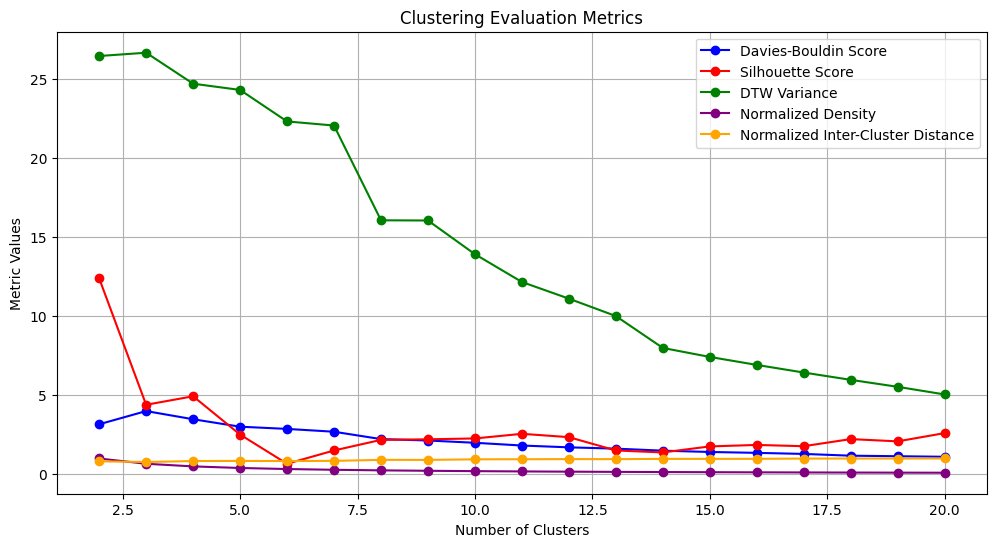

In [5]:
# Define the range of cluster counts to evaluate
max_clusters = 20
cluster_counts = range(2, max_clusters + 1)
db_scores = []
silhouette_scores = []
dtw_variances = []
cluster_labels = {}
density_scores = []
inter_cluster_distances = []

# Iterate over possible cluster counts
for cluster_count in cluster_counts:
    kmeans = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", max_iter=100, tol=1e-6, random_state=42)
    labels = kmeans.fit_predict(time_series_scaled)
    cluster_labels[cluster_count] = labels
    
    # Compute Distance Scores
    dtw_variance = compute_dtw_within_cluster_variance(time_series_scaled, labels, kmeans.cluster_centers_)
    dtw_variances.append(dtw_variance)

    db_score = davies_bouldin_score(time_series_scaled.reshape(time_series_scaled.shape[0], -1), labels)
    db_scores.append(db_score)

    sil_score = silhouette_score(time_series_scaled.reshape(time_series_scaled.shape[0], -1), labels, metric=lambda x, y: dtw(x.reshape(-1,1), y.reshape(-1,1)))*100
    silhouette_scores.append(sil_score)

    # Compute density and inter-cluster distance (defer normalization)
    density = np.mean([np.sum(labels == i) for i in range(cluster_count)]) / len(labels)
    density_scores.append(density)

    # Compute the average DTW distance between different cluster centers
    if cluster_count > 1:  # Calculate distances only if there is more than one cluster
        inter_distances = [dtw(kmeans.cluster_centers_[i], kmeans.cluster_centers_[j]) for i in range(cluster_count) for j in range(i+1, cluster_count)]
        inter_cluster_distances.append(np.mean(inter_distances))
    else:
        inter_cluster_distances.append(0) 
    #print(f"Cluster Count: {cluster_count}, max_iter: {kmeans.n_iter_}, Davies-Bouldin Score: {db_score}, Silhouette Score: {sil_score}, DTW Variance: {dtw_variance}")
    print(f"Cluster: {cluster_count}, max_iter: {kmeans.n_iter_}, DB Score: {db_score:.3f}, Sil Score: {sil_score:.3f}, DTW Var: {dtw_variance:.3f}, Density: {density:.3f}, InterClusterDist: {np.mean(inter_distances):.3f}")

# Normalize the density scores and inter-cluster distances
max_density = max(density_scores)
density_scores = [d / max_density for d in density_scores]
max_distance = max(inter_cluster_distances)
inter_cluster_distances = [d / max_distance for d in inter_cluster_distances]

# Determine the best cluster count (example: using a simple weighted formula)
# You might customize the criteria for choosing the best cluster count
weighted_scores = [silhouette_scores[i] - db_scores[i] + density_scores[i] + inter_cluster_distances[i] for i in range(len(cluster_counts))]
best_index = np.argmax(weighted_scores)
best_cluster_count = cluster_counts[best_index]
print(f"Best cluster count based on combined criteria: {best_cluster_count}")


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(cluster_counts, db_scores, marker='o', color='b', label='Davies-Bouldin Score')
plt.plot(cluster_counts, silhouette_scores, marker='o', color='r', label='Silhouette Score')
plt.plot(cluster_counts, dtw_variances, marker='o', color='g', label='DTW Variance')
plt.plot(cluster_counts, density_scores, marker='o', color='purple', label='Normalized Density')
plt.plot(cluster_counts, inter_cluster_distances, marker='o', color='orange', label='Normalized Inter-Cluster Distance')
plt.title('Clustering Evaluation Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Metric Values')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
cluster_labels

{2: array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0], dtype=int64),
 3: array([1, 2, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 1, 0, 0, 1, 0, 0, 2,
        2, 1, 0, 2, 0, 2, 0, 0], dtype=int64),
 4: array([3, 2, 2, 0, 2, 0, 0, 0, 0, 0, 3, 3, 3, 2, 2, 1, 3, 0, 1, 3, 3, 2,
        2, 1, 0, 3, 3, 2, 3, 0], dtype=int64),
 5: array([3, 2, 4, 0, 2, 0, 0, 4, 0, 0, 3, 3, 3, 2, 2, 1, 4, 0, 1, 4, 4, 2,
        4, 1, 4, 4, 3, 4, 3, 0], dtype=int64),
 6: array([3, 5, 5, 5, 2, 0, 0, 4, 0, 5, 3, 3, 3, 2, 5, 1, 4, 5, 1, 4, 4, 5,
        4, 1, 4, 4, 3, 4, 3, 5], dtype=int64),
 7: array([3, 6, 5, 5, 2, 0, 0, 6, 0, 5, 3, 3, 3, 2, 5, 1, 4, 6, 1, 4, 4, 5,
        4, 1, 4, 4, 3, 4, 3, 5], dtype=int64),
 8: array([2, 3, 7, 3, 7, 3, 0, 6, 3, 3, 2, 2, 5, 3, 3, 1, 5, 3, 1, 4, 5, 3,
        5, 1, 3, 4, 2, 4, 5, 3], dtype=int64),
 9: array([2, 3, 7, 3, 7, 3, 0, 6, 3, 3, 2, 2, 5, 3, 3, 1, 5, 3, 1, 4, 5, 8,
        8, 1, 3, 4, 2, 4, 5, 3], dtype=int64),
 10: arr

In [7]:
import pickle

# Assuming cluster_labels is already defined and filled with data
# Define the path for saving the pickle file
filename = 'cluster_labels.pkl'

# Save the dictionary to a file
with open(filename, 'wb') as file:
    pickle.dump(cluster_labels, file)

print(f"cluster_labels dictionary has been saved to {filename}")

cluster_labels dictionary has been saved to cluster_labels.pkl


# Load clustering

In [ ]:
columns_to_keep = []

for column_name in df.columns:
    if column_name.startswith('load') and column_name[5:].isdigit():
        user_number = int(column_name[5:])
        if 1 <= user_number <= 30:
            columns_to_keep.append(column_name)

filtered_df = df[columns_to_keep]
filtered_df.reset_index(inplace=True)
filtered_df.head(1)

,Date,load_1,load_2,load_3,load_4,load_5,load_6,load_7,load_8,load_9,...,load_21,load_22,load_23,load_24,load_25,load_26,load_27,load_28,load_29,load_30
0,2010-07-01,1.2,0.179,0.065,0.078,1.859,0.036,1.794,0.146,0.113,...,0.621,0.074,0.117,0.131,0.113,0.575,0.274,0.131,0.264,0.059


### Clustering

C:\Users\rs1044\AppData\Local\Temp\ipykernel_23848\3663830711.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


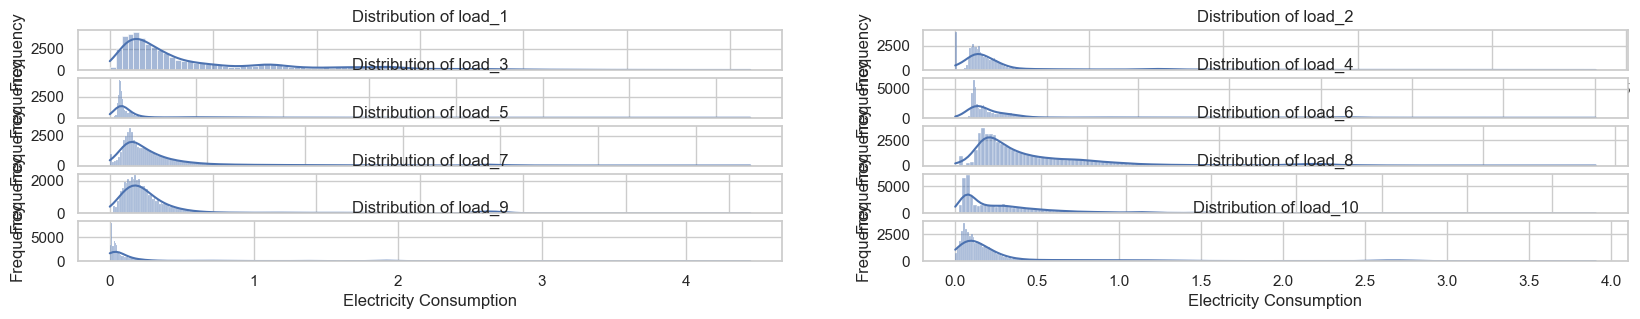

In [ ]:
users_data = filtered_df.iloc[:, 1:11]

sns.set(style="whitegrid")
fig, axes = plt.subplots(5, 2, figsize=(20, 3))  # Adjust the size as needed
axes = axes.flatten()
for i, user in enumerate(users_data.columns):
    sns.histplot(users_data[user], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {user}')
    axes[i].set_xlabel('Electricity Consumption')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Additional function to compute DTW Within-Cluster Variance
def compute_dtw_within_cluster_variance(data, labels, centroids):
    clusters_dtw_variance = []
    for cluster_id in set(labels):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_data = data[cluster_indices]
        centroid = centroids[cluster_id]
        dtw_distances = [dtw.distance(cluster_data[i], centroid) for i in range(len(cluster_data))]
        clusters_dtw_variance.append(np.mean(dtw_distances))
    return np.mean(clusters_dtw_variance)

In [ ]:
metric = "dtw" # "euclidean", "dtw", "softdtw"

#Consider only 1 month, as dtw takes to long otherwise
filtered_df = filtered_df[(filtered_df['Date'].dt.month == 3) & (filtered_df['Date'].dt.year == 2011)]
# Drop date: Focus on Patterns, Not Specific Times / Avoiding Skewed Clusters / Numerical data
data_array = np.array(filtered_df.T.drop('Date').values)
# Scaling - non Gaussian data distributions, no outliers -> use Min-Max not MeanVariance scaling
data_array = MinMaxScaler().fit_transform(data_array)
# Reshape the data array to 2D
data_array_2d = data_array.reshape(data_array.shape[0], -1)

# Specify the maximum number of clusters you want to consider
max_clusters = 20
# Initialize variables to store best parameters
best_cluster_count = 0
best_labels = None
best_db_score = float('inf')  # Davies-Bouldin score
best_silhouette_score = -1    # Silhouette score
best_dtw_variance = float('inf')

# Iterate over possible cluster counts
for cluster_count in range(2, max_clusters + 1):
    kmeans = TimeSeriesKMeans(n_clusters=cluster_count, verbose=False, random_state=42, metric=metric)
    labels = kmeans.fit_predict(data_array)
    np.savetxt(f'../../3final_data/Clusters_KMeans_dtw_c{cluster_count}.csv', labels, delimiter=",")
    centroids = kmeans.cluster_centers_

    # Compute DTW Within-Cluster Variance
    dtw_variance = compute_dtw_within_cluster_variance(data_array, labels, centroids)

    # Evaluate the clustering performance using all scores
    db_score = davies_bouldin_score(data_array, labels)
    sil_score = silhouette_score(data_array, labels)
    print(f"Cluster Count: {cluster_count}, Davies-Bouldin Score: {db_score}, Silhouette Score: {sil_score}, DTW Variance: {dtw_variance}")

    # Update best parameters if the current scores and variance are better
    if db_score < best_db_score and sil_score > best_silhouette_score and dtw_variance < best_dtw_variance:
        best_db_score = db_score
        best_silhouette_score = sil_score
        best_dtw_variance = dtw_variance
        best_cluster_count = cluster_count
        best_labels = labels

# Use the best parameters for final clustering
final_kmeans = TimeSeriesKMeans(n_clusters=best_cluster_count, verbose=False, random_state=42, metric=metric)
final_labels = final_kmeans.fit_predict(data_array)

print("Final labels: ", final_labels)
print("Best cluster count: ", best_cluster_count)
print("Best Davies-Bouldin Score: ", best_db_score)
print("Best Silhouette Score: ", best_silhouette_score)
print("Best DTW Variance: ", best_dtw_variance)

dtw_variance = [3.0044869193855828, 2.5133436056132905, 2.452716918170206,1.854738022617764, 1.8828731296011114, 1.5463779597683391,
                ]

Cluster Count: 2, Davies-Bouldin Score: 2.005419371865691, Silhouette Score: 0.2415845845918193, DTW Variance: 4.077128822679876
Cluster Count: 3, Davies-Bouldin Score: 2.917718513899956, Silhouette Score: 0.07087759990122548, DTW Variance: 3.820181438800153
Cluster Count: 4, Davies-Bouldin Score: 2.556574206986349, Silhouette Score: 0.07523405300420968, DTW Variance: 3.572556695394753
Cluster Count: 5, Davies-Bouldin Score: 2.127420561029424, Silhouette Score: 0.08058077166411474, DTW Variance: 2.744264387114911
Cluster Count: 6, Davies-Bouldin Score: 1.9276986513252707, Silhouette Score: 0.019255232972985085, DTW Variance: 2.7140542880071084
Cluster Count: 7, Davies-Bouldin Score: 1.586056635272102, Silhouette Score: 0.0332095165997294, DTW Variance: 1.875213298134748
Cluster Count: 8, Davies-Bouldin Score: 1.7443219766546747, Silhouette Score: 0.013228113974510538, DTW Variance: 2.196804850231566
Cluster Count: 9, Davies-Bouldin Score: 1.7154730367081201, Silhouette Score: -0.055938

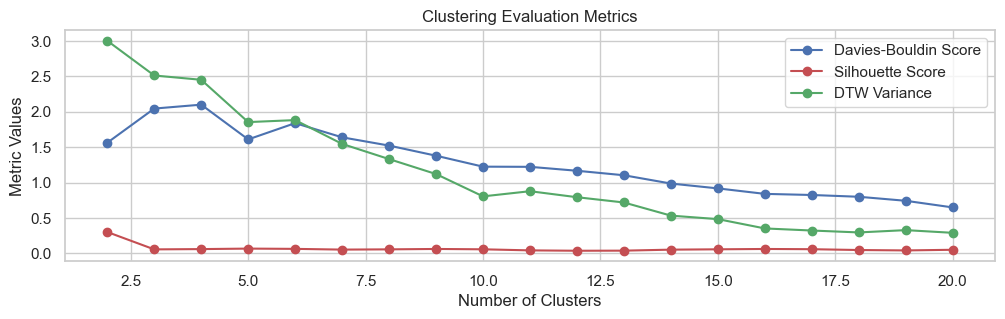

In [ ]:

# Cluster counts
cluster_counts = list(range(2, 21))  # From 2 to 20

# Davies-Bouldin Scores
db_scores = [
    1.5629233491106032, 2.0458146352177398, 2.1011029159995536, 1.6100277526545335, 
    1.8399877225914063, 1.639530572412653, 1.5225584619201271, 1.3794777439213102, 
    1.2247549420299495, 1.2223517388788985, 1.1668536542478154, 1.1032850265724974, 
    0.9859995946133934, 0.9175713707135498, 0.8401124275146481, 0.82429730302733, 
    0.7992410148248442, 0.7423042377556635, 0.6485943728411174
]

# Silhouette Scores
silhouette_scores = [
    0.30112357095295816, 0.055532764232584374, 0.05955310174573076, 0.06654205858849845,
    0.06270759467753095, 0.05243488634725047, 0.05589658842309349, 0.061451000758984714,
    0.056604659932835234, 0.041448280641809845, 0.03618190646223289, 0.0375625268808009,
    0.051703024426026416, 0.05653049942114298, 0.06132449721440641, 0.05811407689951662,
    0.04646952964119131, 0.04071121600979724, 0.04995793883968888
]

# DTW Variances
dtw_variances = [
    3.0044869193855828, 2.5133436056132905, 2.452716918170206, 1.854738022617764,
    1.8828731296011114, 1.5463779597683391, 1.331710178272777, 1.120246645765391,
    0.8048297213631208, 0.8778041277916621, 0.7929583804219607, 0.7183457800995275,
    0.5327322895195126, 0.48317070751792884, 0.3515952142426195, 0.32201378412204645,
    0.2951263917685182, 0.3276774372838609, 0.2895763422190159
]

# Plotting
plt.figure(figsize=(12, 3))
plt.plot(cluster_counts, db_scores, marker='o', color='b', label='Davies-Bouldin Score')
plt.plot(cluster_counts, silhouette_scores, marker='o', color='r', label='Silhouette Score')
plt.plot(cluster_counts, dtw_variances, marker='o', color='g', label='DTW Variance')
plt.title('Clustering Evaluation Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Metric Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Use the best parameters for final clustering
best_cluster_count = 10
final_kmeans = TimeSeriesKMeans(n_clusters=best_cluster_count, verbose=False, random_state=42, metric=metric)
final_labels = final_kmeans.fit_predict(data_array)

print("Final labels: ", final_labels)
#np.savetxt('../../3final_data/Clusters_KMeans10_dtw.csv', final_labels, delimiter=",")

Final labels:  [3 5 2 2 6 1 0 7 2 6 6 6 2 0 2 9 8 0 2 2 4 0 0 6 0 6 6 5 0 2]
Best cluster count:  10
Best Davies-Bouldin Score:  1.5629233491106032
Best Silhouette Score:  0.30112357095295816
Best DTW Variance:  3.0044869193855828


# Calculate cluster-wise dtw distances

In [ ]:
y = np.loadtxt(f'../../../data/3final_data/Clusters_KMeans10_dtw.csv', delimiter=',').astype(int)
num_clusters = 10
cluster_users = {i: [] for i in range(num_clusters)}

# Iterate through each cluster
for cluster_number in range(num_clusters):
    users_in_cluster = np.where(y == cluster_number)[0] +1
    cluster_users[cluster_number] = users_in_cluster
cluster_users

{0: array([ 7, 14, 18, 22, 23, 25, 29], dtype=int64),
 1: array([6], dtype=int64),
 2: array([ 3,  4,  9, 13, 15, 19, 20, 30], dtype=int64),
 3: array([1], dtype=int64),
 4: array([21], dtype=int64),
 5: array([ 2, 28], dtype=int64),
 6: array([ 5, 10, 11, 12, 24, 26, 27], dtype=int64),
 7: array([8], dtype=int64),
 8: array([17], dtype=int64),
 9: array([16], dtype=int64)}

In [ ]:
# Load the CSV file
cluster_df = pd.read_csv('../../../data/3final_data/Clusters_KMeans10_dtw.csv', delimiter=",", header=None)

# Set the column name
cluster_df.columns = ['Cluster']
cluster_df['Cluster'] = cluster_df['Cluster'] + 1

# Create an index column named 'User' starting from 1
cluster_df.index = range(1, len(cluster_df) + 1)
cluster_df.index.name = 'User'

# Display the DataFrame
cluster_df

,Cluster
User,
1,4.0
2,6.0
3,3.0
4,3.0
5,7.0
6,2.0
7,1.0
8,8.0
9,3.0


In [ ]:
metric = "dtw" # "euclidean", "dtw", "softdtw"

#Consider only 1 month, as dtw takes to long otherwise
filtered_df = filtered_df[(filtered_df['Date'].dt.month == 3) & (filtered_df['Date'].dt.year == 2011)]
# Drop date: Focus on Patterns, Not Specific Times / Avoiding Skewed Clusters / Numerical data
data_array = np.array(filtered_df.T.drop('Date').values)
# Scaling - non Gaussian data distributions, no outliers -> use Min-Max not MeanVariance scaling
data_array = MinMaxScaler().fit_transform(data_array)
# Reshape the data array to 2D
data_array_2d = data_array.reshape(data_array.shape[0], -1)

In [ ]:
def compute_dtw_distance_for_clusters(cluster_df, data_array):
    cluster_dtw_distances = {}

    # Iterate through each cluster
    for cluster_id in cluster_df['Cluster'].unique():
        user_indices = cluster_df[cluster_df['Cluster'] == cluster_id].index - 1  # Adjust index if necessary
        cluster_data = data_array[user_indices]
        
        # Calculate centroid of this cluster
        centroid = np.mean(cluster_data, axis=0)

        # Calculate DTW distance for each user in the cluster and get the average
        dtw_distances = [dtw.distance(user_data, centroid) for user_data in cluster_data]
        cluster_dtw_distances[cluster_id] = np.mean(dtw_distances)

    return cluster_dtw_distances

# Calculate DTW distances for each cluster
dtw_distances_per_cluster = compute_dtw_distance_for_clusters(cluster_df, data_array)

# Print DTW distance for each cluster
agg_dtw = 0
for cluster_id, dtw_distance in dtw_distances_per_cluster.items():
    agg_dtw += dtw_distance
    print(f"Cluster {cluster_id}: Average DTW Distance = {dtw_distance.round(2)}")
print("Total: ", agg_dtw, " and mean: ", agg_dtw/10)

Cluster 4.0: Average DTW Distance = 0.0
Cluster 6.0: Average DTW Distance = 2.98
Cluster 3.0: Average DTW Distance = 1.95
Cluster 7.0: Average DTW Distance = 3.27
Cluster 2.0: Average DTW Distance = 0.0
Cluster 1.0: Average DTW Distance = 3.71
Cluster 8.0: Average DTW Distance = 0.0
Cluster 10.0: Average DTW Distance = 0.0
Cluster 9.0: Average DTW Distance = 0.0
Cluster 5.0: Average DTW Distance = 0.0
Total:  11.913392096705316  and mean:  1.1913392096705315
